In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [47]:
# Load dataset
data = pd.read_csv('data/spotify_cleaned.csv')

# Feature columns
feature_cols = [
    "danceability",
    "energy",
    "valence",
    "tempo",
    "acousticness",
    "instrumentalness",
    "liveness",
    "speechiness",
    "loudness"
]

# Feature matrix
X = data[feature_cols].values
X_scaled = StandardScaler().fit_transform(X)

input_dim = X_scaled.shape[1]  # Number of features
print(f'Input dimension: {input_dim}')

Input dimension: 9


In [48]:
# Encoder: feature -> embedding
encoder = Sequential(name="encoder")
encoder.add(Dense(256, activation='relu', input_shape=(input_dim,)))
encoder.add(Dropout(0.2))
encoder.add(Dense(128, activation='relu'))
encoder.add(Dropout(0.2))
encoder.add(Dense(64, activation='relu', name="embedding_layer"))

c:\Users\Aaron\anaconda3\envs\gpu-kernel\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
# Decoder: embedding -> reconstructed feature
decoder = Sequential(name="decoder")
decoder.add(Dense(128, activation='relu', input_shape=(64,)))
decoder.add(Dropout(0.2))
decoder.add(Dense(256, activation='relu'))
decoder.add(Dropout(0.2))
decoder.add(Dense(input_dim, activation='linear'))

In [50]:
# Full autoencoder: feature -> embedding -> reconstructed feature
autoencoder = Sequential(name="autoencoder")
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (None, 64)             │        43,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 9)              │        43,657 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,369 (341.29 KB)

 Trainable params: 87,369 (341.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.3955 - val_loss: 0.0491
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1557 - val_loss: 0.0289
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1306 - val_loss: 0.0239
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1171 - val_loss: 0.0199
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1105 - val_loss: 0.0168
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1049 - val_loss: 0.0169
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1008 - val_loss: 0.0161
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0978 - val_loss: 0.0148
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0958 - val_loss: 0.0129
Epoch 10/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0926 - val_loss: 0.0148
Epoch 11/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0909 - val_loss: 0.0134
Epoch 12/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0884 - val_l

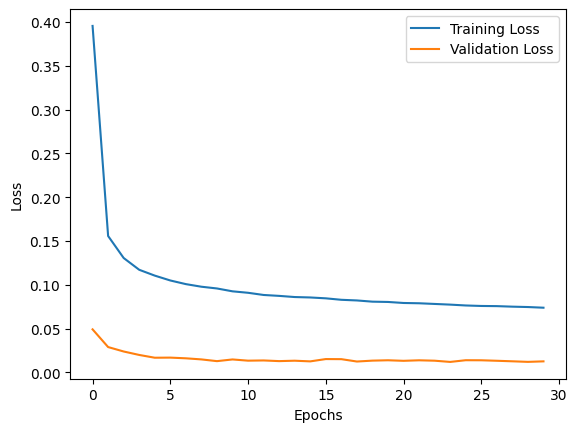

In [51]:
early_stopping = EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = autoencoder.fit(
    X_scaled,
    X_scaled,
    epochs=30,
    batch_size=256,
    validation_split=0.1,
    shuffle=True,
    verbose=1,
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
song_embeddings = encoder.predict(X_scaled, batch_size=256)
print("Embeddings shape:", song_embeddings.shape)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Embeddings shape: (19419, 64)


In [53]:
def find_song_indices(df, track_name=None, track_artist=None):
    mask = pd.Series(True, index=df.index)

    if track_name is not None:
        mask &= df["track_name"].str.contains(
            track_name,
            case=False,
            na=False,
            regex=False,   
        )

    if track_artist is not None:
        mask &= df["track_artist"].str.contains(
            track_artist,
            case=False,
            na=False,
            regex=False,
        )

    return df[mask].index.tolist()


In [54]:
def get_recommendations(song_queries, data, embedding_model, top_n=10):
    # Handle single song dict or list of songs
    if isinstance(song_queries, dict):
        song_queries = [song_queries]
    
    # Collect all seed indices
    seed_indices = []
    for song in song_queries:
        matched_indices = find_song_indices(
            data,
            track_name=song.get("track_name"),
            track_artist=song.get("track_artist")
        )
        if matched_indices:
            seed_indices.append(matched_indices[0])
            print(f"Using seed song: '{data.loc[matched_indices[0], 'track_name']}' by {data.loc[matched_indices[0], 'track_artist']}")
    
    if not seed_indices:
        print("No matching songs found for the given queries.")
        return []
    
    # Get average embedding of all seed songs
    seed_embeddings = song_embeddings[seed_indices]
    avg_seed_embedding = seed_embeddings.mean(axis=0, keepdims=True)
    
    # Compute cosine similarity to all songs
    similarities = cosine_similarity(avg_seed_embedding, song_embeddings).flatten()
    
    # Sort by similarity (descending)
    similar_indices = np.argsort(similarities)[::-1]
    
    # Filter out seed songs and duplicates
    seen = set()
    recommendations = []
    for idx in similar_indices:
        if idx in seed_indices:
            continue
        track_key = (data.loc[idx, "track_name"], data.loc[idx, "track_artist"])
        if track_key in seen:
            continue
        seen.add(track_key)
        recommendations.append({
            "track_name": data.loc[idx, "track_name"],
            "track_artist": data.loc[idx, "track_artist"],
            "similarity": similarities[idx]
        })
        if len(recommendations) >= top_n:
            break
    
    # Pretty print
    print(f"\nTop {top_n} recommendations:")
    for i, rec in enumerate(recommendations, start=1):
        print(f"{i}. '{rec['track_name']}' by {rec['track_artist']} (similarity: {rec['similarity']:.4f})")
    
    return recommendations

In [55]:
# Example usage
user_songs = [
    {"track_name": "Don't you forget about me", "track_artist": "Simple Minds"},
    {"track_name": "Don't stop believin'", "track_artist": "Journey"},
    {"track_name": "Tainted Love", "track_artist": "Soft Cell"},
    {"track_name": "Take on Me", "track_artist": "a-ha"},
    {"track_name": "Africa", "track_artist": "Toto"},
    {"track_name": "Eye of the Tiger", "track_artist": "Survivor"},
]
# Get recommendations for each song in the list
recs = get_recommendations(
    song_queries=user_songs,
    data=data,
    embedding_model=encoder,
    top_n=10
)

Using seed song: 'Don't Stop Believin'' by Journey
Using seed song: 'Tainted Love' by Soft Cell
Using seed song: 'Take on Me' by a-ha
Using seed song: 'Africa' by TOTO
Using seed song: 'Eye of the Tiger' by Survivor

Top 10 recommendations:
1. 'Butterfly' by Molella (similarity: 0.9301)
2. 'Your Dog' by Soccer Mommy (similarity: 0.9293)
3. 'Sweet Home Alabama' by Lynyrd Skynyrd (similarity: 0.9272)
4. 'Fantasy' by Mariah Carey (similarity: 0.9236)
5. 'Last Kiss' by Pearl Jam (similarity: 0.9204)
6. 'Into The Great Wide Open' by Tom Petty and the Heartbreakers (similarity: 0.9161)
7. 'Maria João' by Paula Caju (similarity: 0.9159)
8. 'Sunshine Of Your Love' by Cream (similarity: 0.9147)
9. 'Dreamlover' by Mariah Carey (similarity: 0.9136)
10. 'Love Saw It (Duet with Karyn White)' by Babyface (similarity: 0.9136)


In [56]:
import random
def backtest_playlist(playlistname, seed=.8, n_rec=10):
    # Load playlist data with error handling for malformed CSV
    playlist_df = pd.read_csv('data/spotify_playlists.csv', on_bad_lines='skip', engine='python')
    
    # Convert playlistname column to string to avoid float/type issues
    playlist_df['playlistname'] = playlist_df['playlistname'].astype(str)

    # List of tuples (track_name, track_artist) for all songs in the playlist
    playlist_songs = list(
        playlist_df[playlist_df['playlistname'] == str(playlistname)][['trackname', 'artistname']]
        .itertuples(index=False, name=None)
    )

    songCount = len(playlist_songs)
    
    # Remove songs not in data
    valid_songs = []
    for track_name, track_artist in playlist_songs:
        matches = find_song_indices(data, track_name=track_name, track_artist=track_artist)
        if matches:
            valid_songs.append((track_name, track_artist))

    validCount = len(valid_songs)

    # Randomly choose seed songs
    seed_songs = random.sample(valid_songs, min(int(np.floor(validCount * seed)), validCount))

    # Remove seed songs from valid songs (these are the "held-out" targets)
    for song in seed_songs:
        valid_songs.remove(song)

    # Prepare song queries for recommendation
    song_queries = [
        {"track_name": track_name, "track_artist": track_artist}
        for track_name, track_artist in seed_songs
    ]

    recs = get_recommendations(
        song_queries=song_queries,
        data=data,
        embedding_model=encoder,
        top_n=n_rec
    )

    # 🔧 FIX: if recs is a list, convert to DataFrame
    if isinstance(recs, list):
        recs = pd.DataFrame(recs)

    display(recs)

    # Print summary
    print(f"\nBacktest Summary for Playlist: {playlistname}")
    print(f"Total songs in playlist: {songCount}")
    print(f"Valid songs in dataset: {validCount}")
    print(f"Seed songs used: {len(seed_songs)}")
    print(f"Recommendations generated: {len(recs)}")

    # Calculate how many recommendations were actually in the original playlist
    rec_in_playlist = 0
    for _, row in recs.iterrows():
        if (row['track_name'], row['track_artist']) in valid_songs:
            rec_in_playlist += 1

    print(f"Recommendations in original playlist: {rec_in_playlist}")

    # Optional: hit-rate metric
    if len(recs) > 0:
        hit_rate = rec_in_playlist / len(recs)
        print(f"Hit rate (fraction of recs in playlist): {hit_rate:.3f}")

    return recs


In [57]:
backtest_playlist('Songs I Need', .8, 50)

Using seed song: 'Dreams - 2004 Remaster' by Fleetwood Mac
Using seed song: 'Bitter Sweet Symphony' by The Verve
Using seed song: 'Free Fallin'' by Tom Petty
Using seed song: 'Unwell' by Matchbox Twenty
Using seed song: 'Starships' by Nicki Minaj
Using seed song: 'Paranoid Android - Remastered' by Radiohead
Using seed song: 'Firework' by Katy Perry
Using seed song: 'Grace' by Jeff Buckley
Using seed song: 'Kids' by MGMT
Using seed song: 'Somebody That I Used To Know' by Gotye
Using seed song: 'Refugee' by Tom Petty and the Heartbreakers
Using seed song: 'Paradise City' by Guns N' Roses
Using seed song: 'The Look' by Roxette
Using seed song: 'Scream & Shout' by will.i.am
Using seed song: 'Last Goodbye' by Jeff Buckley
Using seed song: 'Iris' by The Goo Goo Dolls
Using seed song: 'Any Way You Want It' by Journey
Using seed song: 'Rolling in the Deep' by Adele
Using seed song: 'Every Breath You Take' by The Police
Using seed song: 'Use Somebody' by Kings of Leon
Using seed song: 'You Need

,track_name,track_artist,similarity
0,Save Me (feat. Eneli) (feat. Eneli) - Mert Oks...,Mahmut Orhan,0.914862
1,Magic,Vacation Manor,0.913270
2,Butterfly,Molella,0.912977
3,Free-For-All,Ted Nugent,0.912184
4,Daylight,Matt and Kim,0.906480
5,Sweet Emotion - Single Version,Aerosmith,0.902730
6,Don't Look Down,Martin Garrix,0.900753
7,Take Me Out,Franz Ferdinand,0.899830
8,Blue Savannah,Erasure,0.899518
9,Nothing Like You,Lucas Estrada,0.899337



Backtest Summary for Playlist: Songs I Need
Total songs in playlist: 367
Valid songs in dataset: 52
Seed songs used: 41
Recommendations generated: 50
Recommendations in original playlist: 0
Hit rate (fraction of recs in playlist): 0.000


,track_name,track_artist,similarity
0,Save Me (feat. Eneli) (feat. Eneli) - Mert Oks...,Mahmut Orhan,0.914862
1,Magic,Vacation Manor,0.913270
2,Butterfly,Molella,0.912977
3,Free-For-All,Ted Nugent,0.912184
4,Daylight,Matt and Kim,0.906480
5,Sweet Emotion - Single Version,Aerosmith,0.902730
6,Don't Look Down,Martin Garrix,0.900753
7,Take Me Out,Franz Ferdinand,0.899830
8,Blue Savannah,Erasure,0.899518
9,Nothing Like You,Lucas Estrada,0.899337
